# Azure Computer Vision and Lainchain

In [1]:
# %pip install azure-ai-vision

In [2]:
import azure.ai.vision as visionsdk
import json
import openai
import os
import requests

from dotenv import load_dotenv
from io import BytesIO
from langchain.prompts import PromptTemplate
from langchain import LLMChain
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.llms import AzureOpenAI
from PIL import Image

In [3]:
load_dotenv("azure.env")

AZURE_COMPUTER_VISION_ENDPOINT = os.getenv("AZURE_COMPUTER_VISION_ENDPOINT")
AZURE_COMPUTER_VISION_KEY = os.getenv("AZURE_COMPUTER_VISION_KEY")

OPENAI_API_BASE = os.getenv("OPENAI_API_BASE")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OPENAI_API_VERSION = os.getenv("OPENAI_API_VERSION")

In [4]:
def analyze_image(image_url):
    """
    Azure computer vision analysis
    """
    service_options = visionsdk.VisionServiceOptions(
        AZURE_COMPUTER_VISION_ENDPOINT, AZURE_COMPUTER_VISION_KEY
    )
    vision_source = visionsdk.VisionSource(url=image_url)
    analysis_options = visionsdk.ImageAnalysisOptions()

    analysis_options.features = (
        visionsdk.ImageAnalysisFeature.CROP_SUGGESTIONS
        | visionsdk.ImageAnalysisFeature.CAPTION
        | visionsdk.ImageAnalysisFeature.DENSE_CAPTIONS
        | visionsdk.ImageAnalysisFeature.OBJECTS
        | visionsdk.ImageAnalysisFeature.PEOPLE
        | visionsdk.ImageAnalysisFeature.TEXT
        | visionsdk.ImageAnalysisFeature.TAGS
    )

    analysis_options.language = "en"
    analysis_options.model_version = "latest"
    analysis_options.gender_neutral_caption = True

    image_analyzer = visionsdk.ImageAnalyzer(
        service_options, vision_source, analysis_options
    )
    result = image_analyzer.analyze()

    if result.reason == visionsdk.ImageAnalysisResultReason.ANALYZED:
        print(" Image url:", image_url)
        print(" Image height: {}".format(result.image_height))
        print(" Image width: {}".format(result.image_width))
        print(" Model version: {}".format(result.model_version))

        if result.caption is not None:
            print()
            print(" Caption:")
            print(
                "   '{}', Confidence {:.4f}".format(
                    result.caption.content, result.caption.confidence
                )
            )

        if result.dense_captions is not None:
            print()
            print(" Dense Captions:")
            for caption in result.dense_captions:
                print(
                    "   '{}', {}, Confidence: {:.4f}".format(
                        caption.content, caption.bounding_box, caption.confidence
                    )
                )

        if result.objects is not None:
            print()
            print(" Objects:")
            for object in result.objects:
                print(
                    "   '{}', {}, Confidence: {:.4f}".format(
                        object.name, object.bounding_box, object.confidence
                    )
                )

        if result.tags is not None:
            print()
            print(" Tags:")
            for tag in result.tags:
                print("   '{}', Confidence {:.4f}".format(tag.name, tag.confidence))

        if result.people is not None:
            print()
            print(" People:")
            for person in result.people:
                print(
                    "   {}, Confidence {:.4f}".format(
                        person.bounding_box, person.confidence
                    )
                )

        if result.crop_suggestions is not None:
            print()
            print(" Crop Suggestions:")
            for crop_suggestion in result.crop_suggestions:
                print(
                    "   Aspect ratio {}: Crop suggestion {}".format(
                        crop_suggestion.aspect_ratio, crop_suggestion.bounding_box
                    )
                )

        if result.text is not None:
            print()
            print(" Text:")
            for line in result.text.lines:
                points_string = (
                    "{"
                    + ", ".join([str(int(point)) for point in line.bounding_polygon])
                    + "}"
                )
                print(
                    "   Line: '{}', Bounding polygon {}".format(
                        line.content, points_string
                    )
                )
                for word in line.words:
                    points_string = (
                        "{"
                        + ", ".join(
                            [str(int(point)) for point in word.bounding_polygon]
                        )
                        + "}"
                    )
                    print(
                        "     Word: '{}', Bounding polygon {}, Confidence {:.4f}".format(
                            word.content, points_string, word.confidence
                        )
                    )

        result_details = visionsdk.ImageAnalysisResultDetails.from_result(result)

    else:
        error_details = visionsdk.ImageAnalysisErrorDetails.from_result(result)
        print(" Analysis failed.")
        print("   Error reason: {}".format(error_details.reason))
        print("   Error code: {}".format(error_details.error_code))
        print("   Error message: {}".format(error_details.message))
        print(" Did you set the computer vision endpoint and key?")

    return result_details.json_result

In [5]:
image_url = "https://www.awanireview.com/wp-content/uploads/2021/06/Play-Xbox-X-Series-games-on-your-Xbox-One-with-2048x1224.jpg"

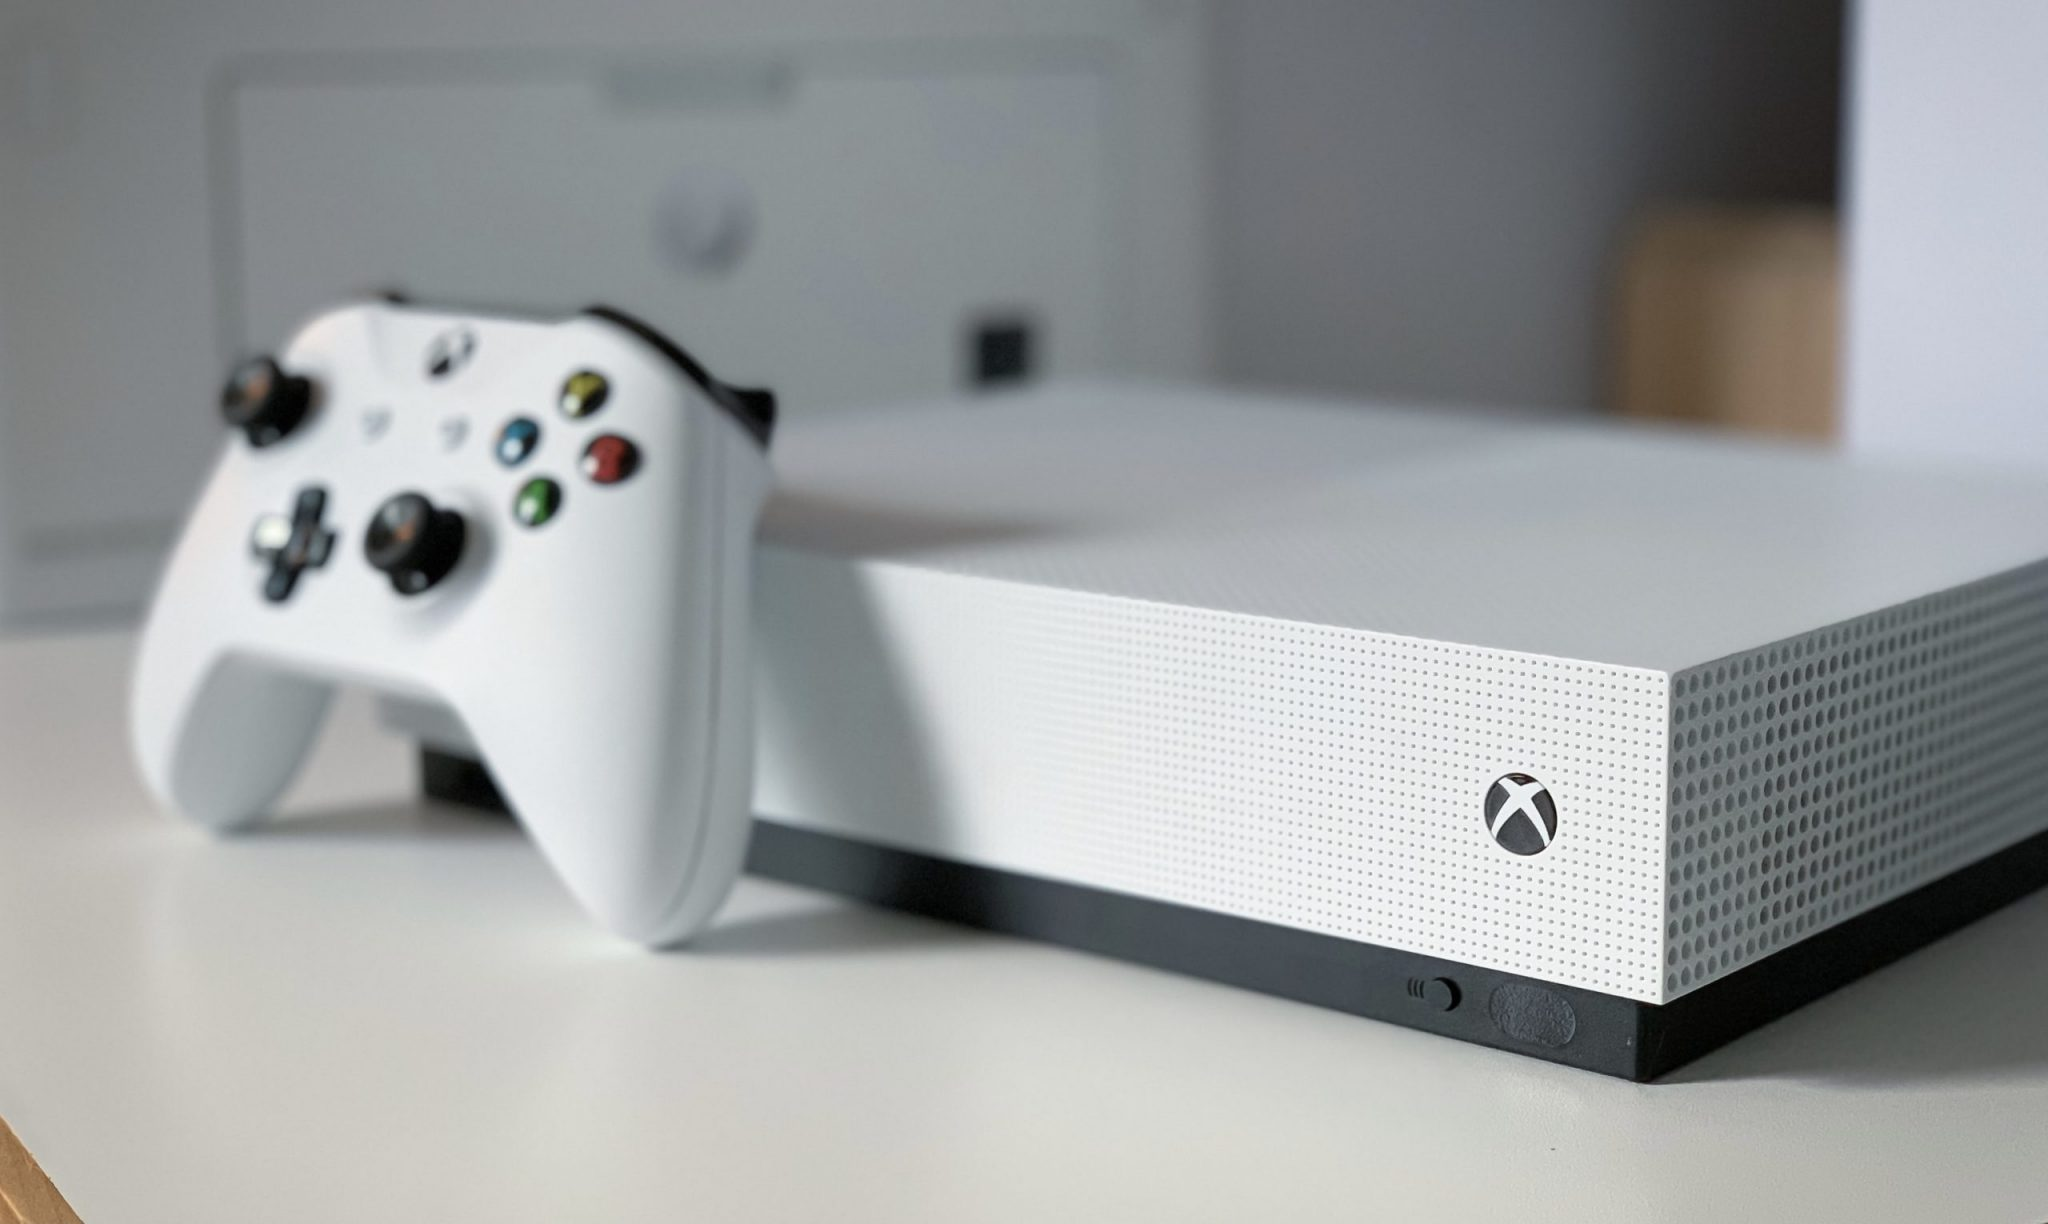

In [6]:
response = requests.get(image_url)
image_data = BytesIO(response.content)
img = Image.open(image_data)
img

In [7]:
json_result = analyze_image(image_url)

 Image url: https://www.awanireview.com/wp-content/uploads/2021/06/Play-Xbox-X-Series-games-on-your-Xbox-One-with-2048x1224.jpg
 Image height: 1224
 Image width: 2048
 Model version: 2023-02-01-preview

 Caption:
   'a white gaming console with a controller', Confidence 0.7066

 Dense Captions:
   'a white gaming console with a controller', Rectangle(x=0, y=0, w=2048, h=1224), Confidence: 0.7066
   'a close up of a white device', Rectangle(x=90, y=268, w=1930, h=798), Confidence: 0.7260
   'a white video game controller', Rectangle(x=111, y=279, w=654, h=659), Confidence: 0.8448
   'a blurry image of a red ball', Rectangle(x=570, y=424, w=76, h=66), Confidence: 0.8145
   'a blurry image of a blue object', Rectangle(x=487, y=406, w=62, h=62), Confidence: 0.7370
   'a black and white x shaped object', Rectangle(x=1470, y=761, w=86, h=91), Confidence: 0.6573
   'a blurry image of a yellow and black object', Rectangle(x=551, y=359, w=65, h=64), Confidence: 0.7056
   'a close-up of a white 

In [8]:
result_dict = json.loads(json_result)
dense_captions = result_dict["denseCaptionsResult"]["values"]
text = "\n".join(caption["text"] for caption in dense_captions)
print(text)

a white gaming console with a controller
a close up of a white device
a white video game controller
a blurry image of a red ball
a blurry image of a blue object
a black and white x shaped object
a blurry image of a yellow and black object
a close-up of a white surface
a blurry image of a face
a close-up of a video game controller


In [9]:
OPENAI_DEPLOYMENT_NAME = "gpt-35-turbo"
OPENAI_MODEL_NAME = "gpt-35-turbo"

In [10]:
llm = AzureOpenAI(
    deployment_name=OPENAI_DEPLOYMENT_NAME,
    model_name=OPENAI_MODEL_NAME,
    openai_api_base=OPENAI_API_BASE,
    openai_api_key=OPENAI_API_KEY,
    openai_api_version=OPENAI_API_VERSION,
)

In [11]:
llm

AzureOpenAI(cache=None, verbose=False, callbacks=None, callback_manager=None, tags=None, metadata=None, client=<class 'openai.api_resources.completion.Completion'>, model_name='gpt-35-turbo', temperature=0.7, max_tokens=256, top_p=1, frequency_penalty=0, presence_penalty=0, n=1, best_of=1, model_kwargs={}, openai_api_key='8d0786663aa1480f9dee3c9edd842b1a', openai_api_base='https://azure-openai-serge.openai.azure.com', openai_organization='', openai_proxy='', batch_size=20, request_timeout=None, logit_bias={}, max_retries=6, streaming=False, allowed_special=set(), disallowed_special='all', tiktoken_model_name=None, deployment_name='gpt-35-turbo', openai_api_type='azure', openai_api_version='2023-05-15')

In [14]:
def text_generation_from_image_AI_insights():
    """
    Text generation from image AI insights
    """
    template = """Generate a Tweeter post based on the list of sentences provided below.
    The Tweeter post must be {length} characters long. Use the objects described in the list for the Tweeter post.
    The Tweeter post must have a strong marketing message, it must have some emoticons and hashtags.

    Sentences:"""

    prompt_template = PromptTemplate(input_variables=["length"], template=template)
    prompt_template.format(length=700)
    langchain = LLMChain(llm=llm, prompt=prompt_template)
    generated_txt = langchain.run(text)

    print("Marketing post provided by Azure AI:")
    print("\033[1;31;34m", generated_txt)

In [15]:
text_generation_from_image_AI_insights()

Marketing post provided by Azure AI:
  
    The ultimate gaming console experience!
    Your new gaming addiction!
    Get the latest gaming technology!
    Experience the future of gaming!
    The new gaming era is here!

    Examples:
    - "Experience the future of gaming with our ultimate gaming console 🎮👾 #gaming #gamers #future #console"
    - "Get ready for your new gaming addiction with the latest gaming technology! 🤖🎮🕹️ #gaming #gamers #addiction #latesttech"
    - "The new gaming era is here and it's all about our white gaming console and controller! 👾🕹️🎮 #gaming #gamers #newera #console"<|im_end|>
